In [22]:
import torch, re
import torch.utils.data as data_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [43]:
def load_data(tokenizer):
    ds = []
    # Read from src
    with open('data/train_set.fasta') as f:
        lines = f.read().split(">")[1:]
        ds = [0]*len(lines)
        for i, line in enumerate(tqdm(lines)):
            seq, sep = line.strip().split("\n")[1:]
            seq = list(seq)
            sep = re.sub("S|T|L|P", "0", sep) # simplify to SP existance
            sep = re.sub("I|M|O",   "1", sep) # simplify to SP non-existance
            sep = [float(i) for i in sep]
            ds[i] = {
                'seq': seq,
                'sep': sep
            }
    # Tokenize data
    ds = [dict(item, **{'tokenized':tokenizer(item['seq'], return_tensors="pt")}) for item in ds]
    return ds

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
model = AutoModelForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
ds = load_data(tokenizer)
ds = ds[-9443:]

  0%|          | 0/20290 [00:00<?, ?it/s]

100%|██████████| 20290/20290 [00:00<00:00, 34448.25it/s]


In [86]:
model = model.to("cuda")
ds = [dict(item, **{'tokenized':item['tokenized'].to("cuda")}) for item in ds]

In [89]:
sample = ds[0]
seq = sample['seq']
logits = model.forward(**sample['tokenized']).logits
pred = torch.softmax(logits, dim=1)

In [90]:
print("".join(seq))
for p in pred:
    print("1" if torch.argmax(p) == 0 else "0", end="")

MKAVITLLFLACILVVTYGDLICGTNYCKDHPCTSPIARASCRSPATYRANHSGKCACCPACVTLLRERA
0000000000000000000000000000000000000000000000000000000000000000000000

In [91]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.functional.binary_cross_entropy
epochs = 1

In [92]:
dataset = ds[::-1] #data_utils.DataLoader(ds, batch_size=32)
loss_log = []
for epoch in range(epochs):
    loss = 0
    for batch in tqdm(dataset):
        optimizer.zero_grad()
        logits = model.forward(**batch['tokenized']).logits
        pred = torch.nn.functional.softmax(logits, dim=1)
        y_pred = torch.argmax(pred, dim=1).float()

        loss = criterion(y_pred, torch.tensor(batch['sep'], requires_grad=True, device="cuda"))
        loss.backward()
        optimizer.step()
        loss_log.append(loss.cpu().detach().item())

 40%|███▉      | 3733/9443 [04:47<07:20, 12.97it/s]


KeyboardInterrupt: 

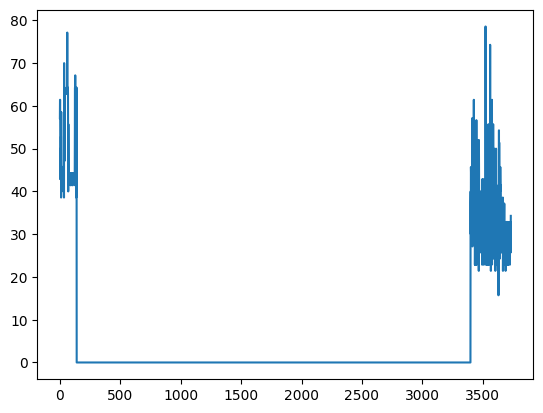

In [93]:
plt.plot(loss_log)

In [115]:
test = list("MDLSTKKVISAGLVFIYALSLAMLVPMFLASNQGVISAVINPATGGNCLPGRYSGIVQASGVTLPAVNLS")
test_label = "SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO"
test_label = re.sub("S|T|L|P", "0", test_label)
test_label = re.sub("I|M|O",   "1", test_label)
test_label = [float(t) for t in test_label]
ids = tokenizer(test, return_tensors="pt").to("cuda")
p = model.forward(**ids).logits
label = torch.argmax(p, dim=1)
print(f"{''.join(test)}\n{''.join([str(int(t)) for t in test_label])}\n{''.join([str(l) for l in label.cpu().numpy()])}")

MDLSTKKVISAGLVFIYALSLAMLVPMFLASNQGVISAVINPATGGNCLPGRYSGIVQASGVTLPAVNLS
0000000000000000000000000000001111111111111111111111111111111111111111
1111111111111111111111111111111111111111111111111111111111111111111111


In [84]:
len(list(filter(lambda x: not all(x['sep'] == torch.ones(len(x['sep'])).numpy()), ds[-9443:])))

4665

20290

In [31]:
torch.ones(len(ds[3000]['sep'])).numpy() == [1.]*len(ds[3000]['sep'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
num_epochs = 1
logging_steps = 100

training_args = TrainingArguments(output_dir="./outputs/" + "sp_bert",
                                    logging_dir="./logs",
                                    logging_steps=logging_steps,
                                    logging_first_step=True,
                                    evaluation_strategy="steps",
                                    save_strategy='epoch',
                                    optim='adamw_torch',
                                    num_train_epochs=num_epochs,
                                    auto_find_batch_size=True,
                                    )
trainer = Trainer(
    model=model,
    tokenizer=self.tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=self.__compute_metrics,
)